In [151]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pandas.plotting import register_matplotlib_converters
from scipy.cluster import hierarchy
from sklearn.model_selection import cross_val_predict
import sklearn.model_selection as ms
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters

import re

from datetime import datetime
import traces

%matplotlib inline
plt.style.use('seaborn-whitegrid')

### Preparing FiveThirtyEight Data
#### We are only using polls from pollsters graded at least an A- by FiveThirtyEight
#### Grading criteria: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/

In [152]:
fte = pd.read_csv("data/president_primary_polls.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [153]:
validPollsters = ["Marist College", "Monmouth University", "ABC News/The Washington Post", "Siena College/The New York Times Upshot", "Selzer & Co.", "Muhlenberg College", "SurveyUSA", "Suffolk University", "CBS News/The New York Times", "Emerson College", "Siena College", "Fox News/Beacon Research/Shaw & Co. Research", "RKM Research and Communications Inc.", "NBC News/The Wall Street Journal"]

In [154]:
fte = fte[fte.pollster.isin(validPollsters)]
fte = fte[fte.party.isin(["DEM"])]
# We are only intersetd in national wide polling hence why we only want nan results in the state column
fte = fte[fte['state'].isnull()]
fte.head()

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
40,120207,64893,2020,NaN,1102,Emerson College,1185,Nexstar,Emerson College,88.0,...,False,3/20/20 14:57,NaN,http://emersonpolling.com/2020/03/19/march-nat...,primary,DEM,Sanders,13257,Bernard Sanders,42.1
41,120207,64893,2020,NaN,1102,Emerson College,1185,Nexstar,Emerson College,88.0,...,False,3/20/20 14:57,NaN,http://emersonpolling.com/2020/03/19/march-nat...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,53.6
956,119198,64611,2020,NaN,460,SurveyUSA,1180,FairVote,SurveyUSA,325.0,...,False,2/28/20 11:21,NaN,http://www.surveyusa.com/client/PollReport.asp...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,21.0
957,119198,64611,2020,NaN,460,SurveyUSA,1180,FairVote,SurveyUSA,325.0,...,False,2/28/20 11:21,NaN,http://www.surveyusa.com/client/PollReport.asp...,primary,DEM,Bloomberg,13289,Michael Bloomberg,21.0
958,119198,64611,2020,NaN,460,SurveyUSA,1180,FairVote,SurveyUSA,325.0,...,False,2/28/20 11:21,NaN,http://www.surveyusa.com/client/PollReport.asp...,primary,DEM,Buttigieg,13345,Pete Buttigieg,9.0


In [155]:
def getTimestamps(df):
    timestamps = list()
    count = 0
    for index, row in df.iterrows():
        timestamps.append(pd.to_datetime(row["created_at"]))
    return timestamps

In [156]:
def buildTuples(df):
    tups = list()
    for index, row in df.iterrows():
        tups.append((row['startDateTs'], row['pct']))
    return tups

In [190]:
def delta(series):
    changes = list()
    for i in range(1,series.size):
        changes.append(series[i] - series[i-1])
    changes = pd.Series(changes)
    changes = changes.fillna(0)
    return changes

### Biden

In [157]:
bidenBool = fte["candidate_name"] == "Joseph R. Biden Jr."
biden = fte[bidenBool]
biden.insert(2, "startDateTs", getTimestamps(biden), True)
biden = biden.sort_values("startDateTs", ascending = True)
biden.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18548,92397,57075,2018-12-27 03:58:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,12/27/18 03:58,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,25.5
18200,92813,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,45.4
18095,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,29.0
17834,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,27.4
17427,93515,57641,2019-03-11 12:07:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:07,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,28.0


In [158]:
biden.set_index("startDateTs", inplace = True)
rolling = biden.rolling(window=3)
rolling_mean = rolling.mean()
biden["rolling_mean"] = rolling_mean["pct"]

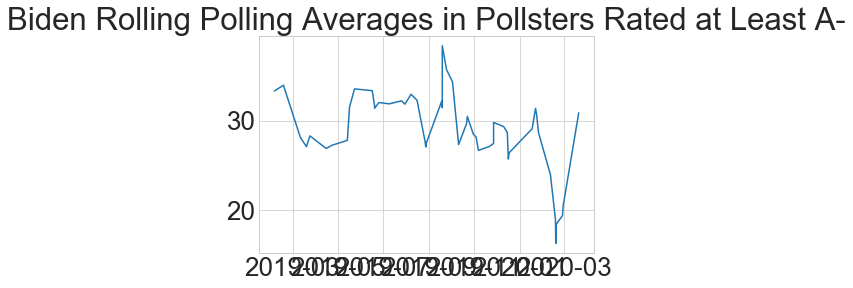

In [159]:
biden = biden.reset_index()
fig = plt.figure()
plt.rcParams.update({'font.size': 26})
plt.plot(biden["startDateTs"], biden["rolling_mean"])
#plt.rcParams['figure.figsize'] = [40, 20]
#plt.rcParams.update({'font.size': 22})
#fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
plt.title("Biden Rolling Polling Averages in Pollsters Rated at Least A-")
plt.show()

In [187]:
bidenTups = buildTuples(biden)
bidenTs = traces.TimeSeries(data= bidenTups)
bidenRegularized = ts.moving_average(100, pandas=True)
# fig = plt.figure()
# #plt.rcParams.update({'font.size': 26})
# plt.plot(regularized.index, regularized.values)
# plt.rcParams['figure.figsize'] = [40, 20]
# plt.rcParams.update({'font.size': 22})
# plt.xlabel("Date")
# plt.ylabel("Percentange")
# #fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
# plt.title("Biden Rolling Polling Averages in Pollsters Rated at Least A-")
# plt.show()

In [191]:
bidenDelta = delta(bidenRegularized)
bidenDelta.to_csv("bidenDelta.csv")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [194]:
bidenChangeDF = pd.DataFrame()
bidenChangeDF['change'] = bidenDelta
bidenChangeDF.index = bidenRegularized.index[1:]
bidenChangeDF.to_csv("bidenChangeDF.csv")
bidenChangeDF

,change
2018-12-27 03:59:40,0.00
2018-12-27 04:01:20,0.00
2018-12-27 04:03:00,0.00
2018-12-27 04:04:40,0.00
2018-12-27 04:06:20,0.00
...,...
2020-03-20 14:49:40,0.00
2020-03-20 14:51:20,0.00
2020-03-20 14:53:00,0.00
2020-03-20 14:54:40,0.00


### Sanders

In [162]:
sandersBool = fte["candidate_name"] == "Bernard Sanders"
sanders = fte[sandersBool]
sanders.insert(2, "startDateTs", getTimestamps(sanders), True)
sanders = sanders.sort_values("startDateTs", ascending = True)
sanders.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18545,92397,57075,2018-12-27 03:58:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,12/27/18 03:58,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Sanders,13257,Bernard Sanders,22.0
18212,92813,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Sanders,13257,Bernard Sanders,5.4
18096,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Sanders,13257,Bernard Sanders,16.0
17832,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Sanders,13257,Bernard Sanders,17.2
17428,93515,57641,2019-03-11 12:07:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:07,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Sanders,13257,Bernard Sanders,25.0


In [163]:
sanders.set_index("startDateTs", inplace = True)
rolling = sanders.rolling(window=3)
rolling_mean = rolling.mean()
sanders["rolling_mean"] = rolling_mean["pct"]

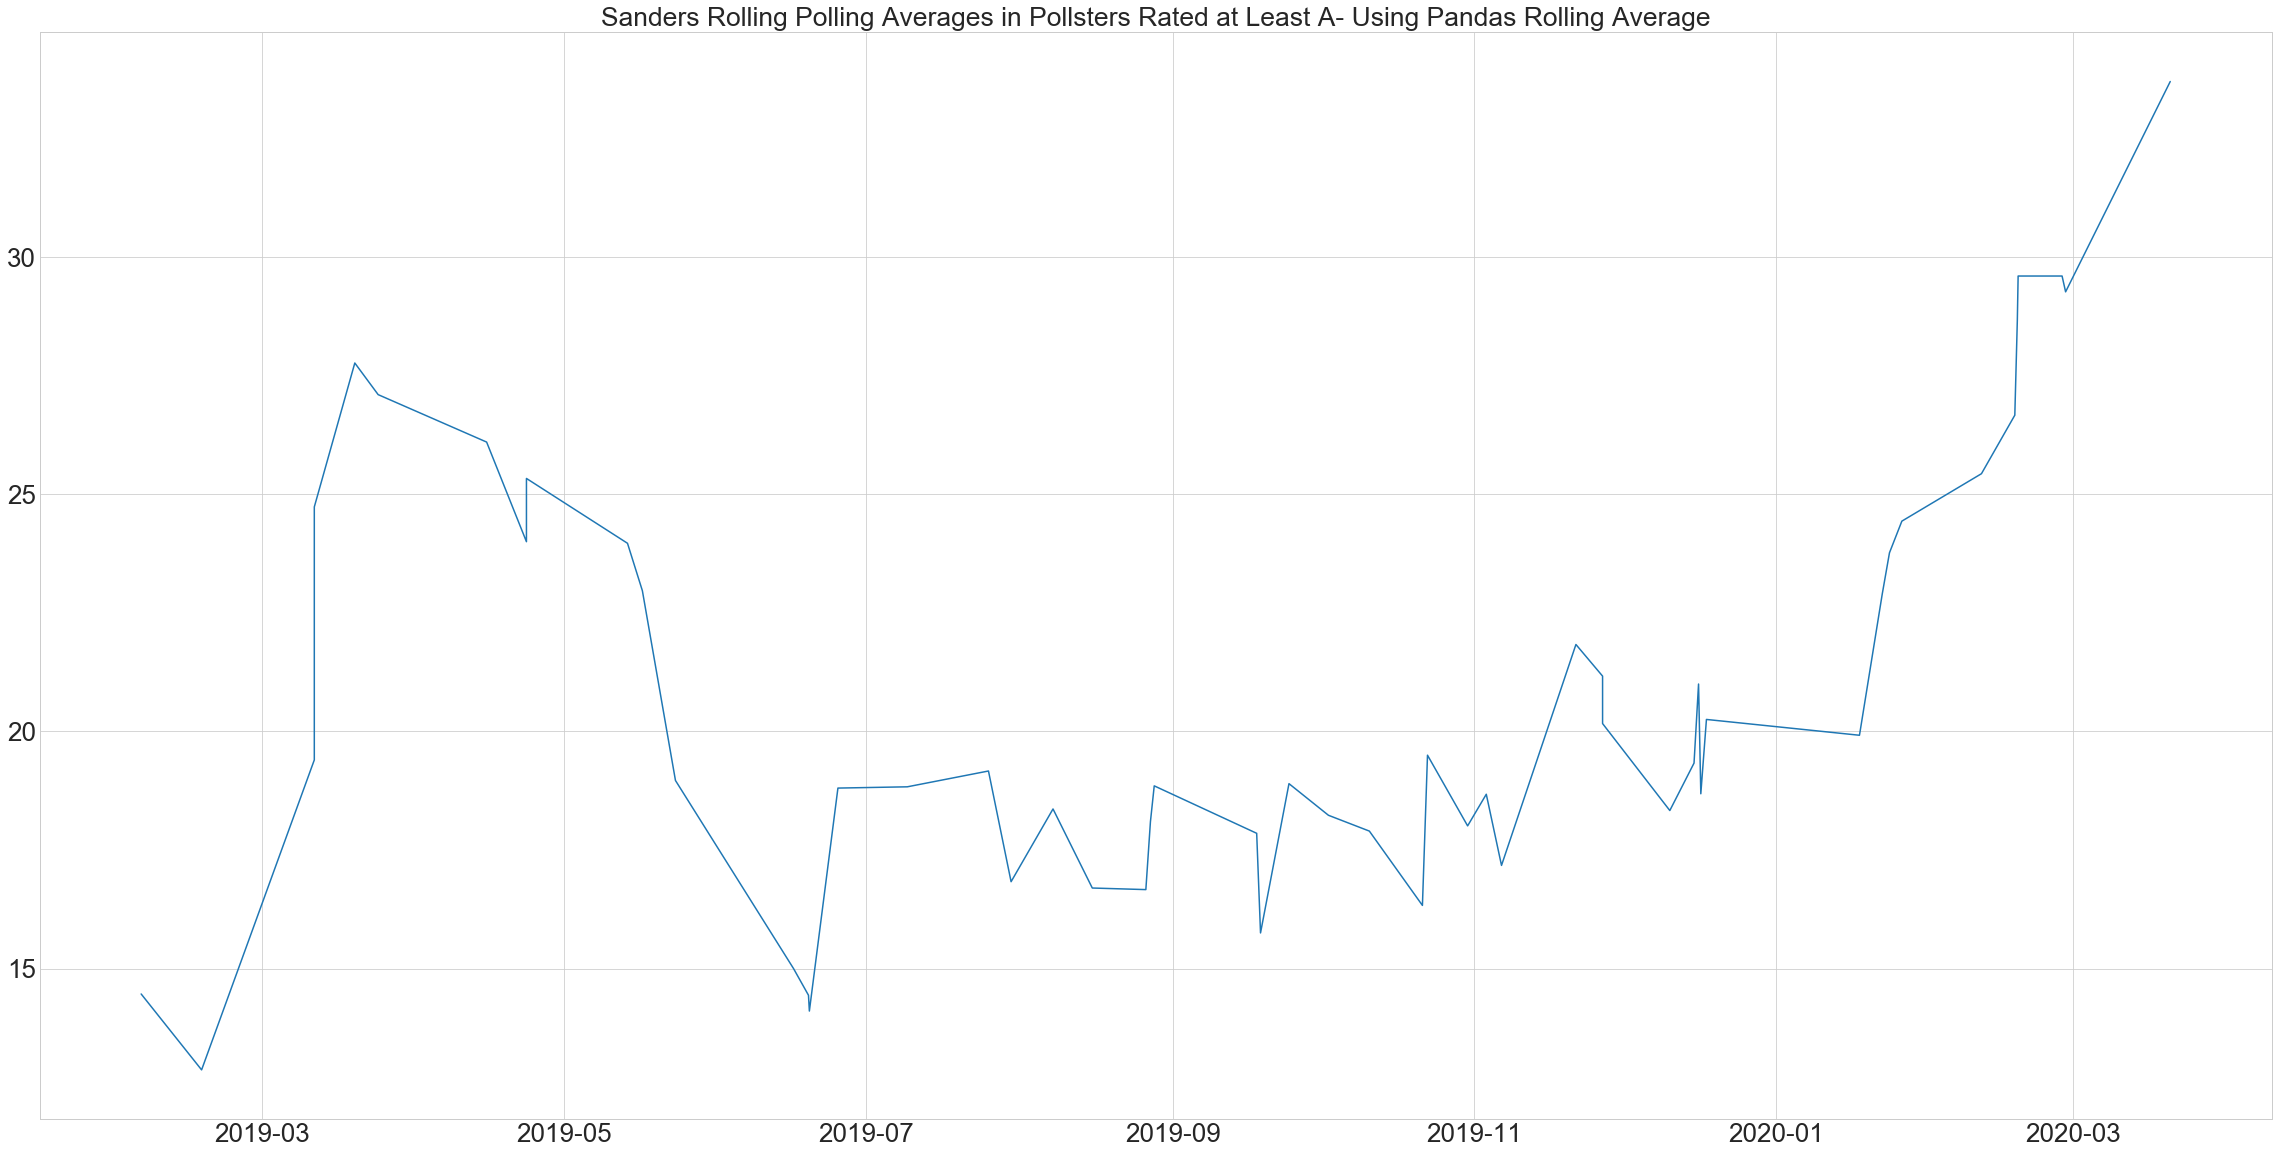

In [164]:
sanders = sanders.reset_index()
fig = plt.figure()
plt.rcParams.update({'font.size': 26})
plt.plot(sanders["startDateTs"], sanders["rolling_mean"])
plt.rcParams['figure.figsize'] = [40, 20]
plt.rcParams.update({'font.size': 22})
#fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
plt.title("Sanders Rolling Polling Averages in Pollsters Rated at Least A- Using Pandas Rolling Average")
plt.show()

In [165]:
sandersTups = buildTuples(sanders)
ts = traces.TimeSeries(data= sandersTups)
sandersRegularized = ts.moving_average(100, pandas=True)
sandersRegularized

2018-12-27 03:58:00    22.00
2018-12-27 03:59:40    22.00
2018-12-27 04:01:20    22.00
2018-12-27 04:03:00    22.00
2018-12-27 04:04:40    22.00
                       ...  
2020-03-20 14:49:40    28.00
2020-03-20 14:51:20    28.00
2020-03-20 14:53:00    28.00
2020-03-20 14:54:40    28.00
2020-03-20 14:56:20    29.41
Length: 388332, dtype: float64

In [193]:
# sandersPollDelta = delta(sandersRegularized)
# sandersPollDelta.to_csv("sandersPollDelta.csv")
sandersPollDelta

0         0.00
1         0.00
2         0.00
3         0.00
4         0.00
          ... 
388326    0.00
388327    0.00
388328    0.00
388329    0.00
388330    1.41
Length: 388331, dtype: float64

In [186]:
sandersChangeDF = pd.DataFrame()
sandersChangeDF['change'] = sandersPollDelta
sandersChangeDF.index = sandersRegularized.index[1:]
sandersChangeDF.to_csv("sandersChangeDF.csv")

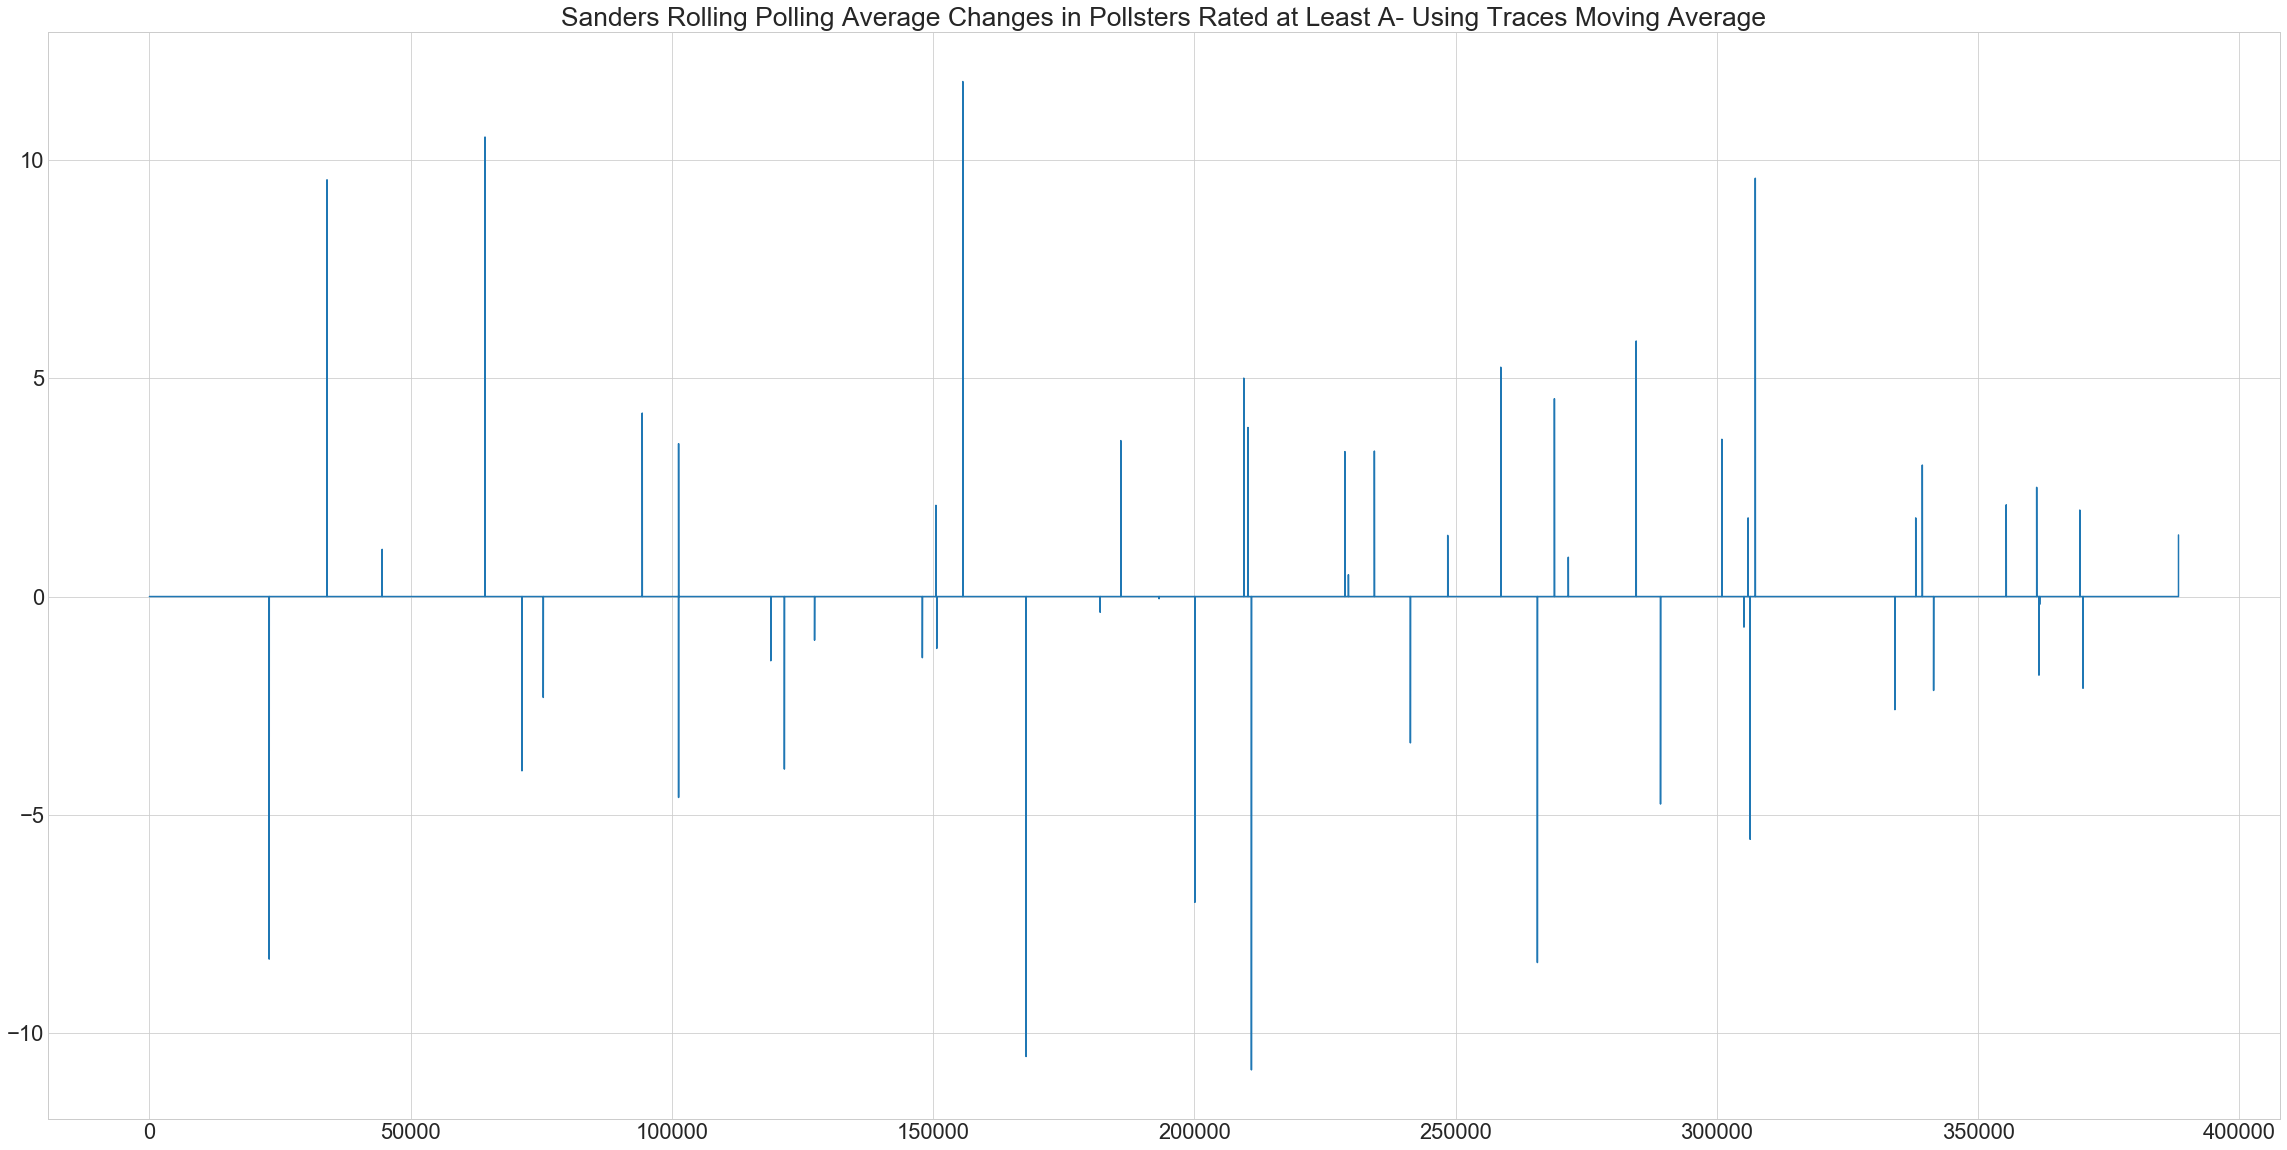

In [170]:
fig = plt.figure()
#plt.rcParams.update({'font.size': 26})
plt.plot(sandersPollDelta.index, sandersPollDelta.values)
plt.rcParams['figure.figsize'] = [40, 20]
plt.rcParams.update({'font.size': 22})
#fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
plt.title("Sanders Rolling Polling Average Changes in Pollsters Rated at Least A- Using Traces Moving Average")
plt.show()

### Buttigieg

In [195]:
buttiBool = fte["candidate_name"] == "Pete Buttigieg"
buttigieg = fte[buttiBool]
buttigieg.insert(2, "startDateTs", getTimestamps(buttigieg), True)
buttigieg = buttigieg.sort_values("startDateTs", ascending = True)
buttigieg.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18105,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Buttigieg,13345,Pete Buttigieg,0.0
17843,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Buttigieg,13345,Pete Buttigieg,0.0
17441,93515,57641,2019-03-11 12:07:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:07,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Buttigieg,13345,Pete Buttigieg,0.0
17464,93516,57641,2019-03-11 12:08:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:08,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Buttigieg,13345,Pete Buttigieg,0.0
17134,93665,57712,2019-03-19 16:36:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,3/19/19 16:36,NaN,http://emersonpolling.com/2019/03/19/national-...,primary,DEM,Buttigieg,13345,Pete Buttigieg,2.9


In [196]:
buttiTups = buildTuples(buttigieg)
ts = traces.TimeSeries(data= buttiTups)
buttigiegRegularized = ts.moving_average(100, pandas=True)
# fig = plt.figure()
# #plt.rcParams.update({'font.size': 26})
# plt.plot(regularized.index, regularized.values)
# plt.rcParams['figure.figsize'] = [40, 20]
# plt.rcParams.update({'font.size': 22})
# #fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
# plt.title("Buttigieg Rolling Polling Averages in Pollsters Rated at Least A-")
# plt.show()

In [197]:
buttigiegDelta = delta(buttigiegRegularized)
buttigiegChangeDF = pd.DataFrame()
buttigiegChangeDF['change'] = buttigiegDelta
buttigiegChangeDF.index = buttigiegRegularized.index[1:]
buttigiegChangeDF.to_csv("buttigiegChangeDF.csv")

### Warren

In [198]:
warrenBool = fte["candidate_name"] == "Elizabeth Warren"
warren = fte[warrenBool]
warren.insert(2, "startDateTs", getTimestamps(warren), True)
warren = warren.sort_values("startDateTs", ascending = True)
warren.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18544,92397,57075,2018-12-27 03:58:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,12/27/18 03:58,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Warren,13258,Elizabeth Warren,6.9
18220,92814,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Warren,13258,Elizabeth Warren,42.9
18213,92813,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Warren,13258,Elizabeth Warren,2.9
18097,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Warren,13258,Elizabeth Warren,8.0
17833,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Warren,13258,Elizabeth Warren,9.2


In [199]:
warren = warren.drop(warren.index[1])

In [200]:
warrenTups = buildTuples(warren)
ts = traces.TimeSeries(data= warrenTups)
warrenRegularized = ts.moving_average(100, pandas=True)
# fig = plt.figure()
# #plt.rcParams.update({'font.size': 26})
# plt.plot(regularized.index, regularized.values)
# plt.rcParams['figure.figsize'] = [40, 20]
# plt.rcParams.update({'font.size': 22})
# #fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
# plt.title("Warren Rolling Polling Averages in Pollsters Rated at Least A-")
# plt.show()

In [201]:
warrenDelta = delta(warrenRegularized)
warrenChangeDF = pd.DataFrame()
warrenChangeDF['change'] = warrenDelta
warrenChangeDF.index = warrenRegularized.index[1:]
warrenChangeDF.to_csv("warrenChangeDF.csv")

### Bloomberg

In [203]:
bloomBool = fte["candidate_name"] == "Michael Bloomberg"
bloomberg = fte[bloomBool]
bloomberg.insert(2, "startDateTs", getTimestamps(bloomberg), True)
bloomberg = bloomberg.sort_values("startDateTs", ascending = True)
bloomberg.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18201,92813,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Bloomberg,13289,Michael Bloomberg,6.6
18099,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Bloomberg,13289,Michael Bloomberg,4.0
17842,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Bloomberg,13289,Michael Bloomberg,2.2
17434,93515,57641,2019-03-11 12:07:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:07,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Bloomberg,13289,Michael Bloomberg,2.0
17456,93516,57641,2019-03-11 12:08:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:08,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Bloomberg,13289,Michael Bloomberg,2.0


In [204]:
bloomTups = buildTuples(bloomberg)
ts = traces.TimeSeries(data= bloomTups)
bloomRegularized = ts.moving_average(100, pandas=True)
# fig = plt.figure()
# #plt.rcParams.update({'font.size': 26})
# plt.plot(regularized.index, regularized.values)
# plt.rcParams['figure.figsize'] = [40, 20]
# plt.rcParams.update({'font.size': 22})
# #fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
# plt.title("Bloomberg Rolling Polling Averages in Pollsters Rated at Least A-")
# plt.show()

In [205]:
bloomDelta = delta(bloomRegularized)
bloomChangeDF = pd.DataFrame()
bloomChangeDF['change'] = bloomDelta
bloomChangeDF.index = bloomRegularized.index[1:]
bloomChangeDF.to_csv("bloomChangeDF.csv")

### Klobuchar

In [206]:
klobBool = fte["candidate_name"] == "Amy Klobuchar"
klobuchar = fte[klobBool]
klobuchar.insert(2, "startDateTs", getTimestamps(klobuchar), True)
klobuchar = klobuchar.sort_values("startDateTs", ascending = True)
klobuchar.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18209,92813,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Klobuchar,13310,Amy Klobuchar,1.4
18100,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Klobuchar,13310,Amy Klobuchar,2.0
17835,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Klobuchar,13310,Amy Klobuchar,4.6
17433,93515,57641,2019-03-11 12:07:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:07,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Klobuchar,13310,Amy Klobuchar,3.0
17455,93516,57641,2019-03-11 12:08:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:08,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Klobuchar,13310,Amy Klobuchar,3.0


In [207]:
klobTups = buildTuples(klobuchar)
ts = traces.TimeSeries(data= klobTups)
klobRegularized = ts.moving_average(100, pandas=True)
# fig = plt.figure()
# #plt.rcParams.update({'font.size': 26})
# plt.plot(regularized.index, regularized.values)
# plt.rcParams['figure.figsize'] = [40, 20]
# plt.rcParams.update({'font.size': 22})
# #fig.legend([ "YouGov","SurveyUSA", "Monmouth University", "ABC News/Washington Post", "Selzer & Co.", "Muhlenberg College", "Suffolk University"])
# plt.title("Klobuchar Rolling Polling Averages in Pollsters Rated at Least A-")
# plt.show()

In [208]:
klobDelta = delta(klobRegularized)
klobChangeDF = pd.DataFrame()
klobChangeDF['change'] = klobDelta
klobChangeDF.index = klobRegularized.index[1:]
klobChangeDF.to_csv("klobChangeDF.csv")